In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from netCDF4 import Dataset
from scipy.optimize import fsolve
import numpy as np
from os import path

In [2]:
# total (direct) disaster damage (i.e., assets / production capital) on a state level, same for both states
D_0 = 30.233e9

year = 2012
states = ['NJ', 'NY']
storm = 'SANDY'

# 1 Economic Losses

We assume different reasons for reduced production after the hurricane:
- **Business interruption outages ($f_{BI}$)**: Due to the biophysical impact of the disaster, businesses cannot operate in the immediate aftermath of the hurricane. We define a duration $t_r$, after which the economy should have recovered from the business interruption shock. The initial forcing intensity $f_{BI}^{(0)}$ of this shock is given by the GDP of the region that is covered by the disaster.
- **Reconstruction outages ('forced investment', $f_R$)**: Damages need to be reconstructed, 'blocking' other production capacities. We assume exponential reconstruction, either 
    - starting with a reconstruction effort at time step $t = 0$ of $\alpha_0 X^*$. $\alpha_0$ is the share of (unperturbed) GDP that an economy can dedicate to reconstruction. Fitting the area to the total damage, this results in a duration for reconstruction, OR
    - setting the reconstruction duration $t_r$ and fitting the area to the total damage, this results in an initial reconstruction effort $\alpha_0$ and time constant $\tau_{R}$
- **Damage outages ($f_D$)**: productive capital would usually create output. Hence, production is reduced by the fraction of productive capital that is (still) destroyed at time step $t$. Initial capital $K_0$ is estimated using the (national) capital-output ratio $r$.

We assume damage and reconstruction outages to add up in an additive way, i.e. $f_D + f_R$.

We further assume that business interruption disturbs the remaining productive capacity and therefore adds up in a multiplicative way. Hence, total forcing results to $f = f_D + f_R + f_{BI}\left(1 - (f_D + f_R)\right)$.

Alternative way:

$f = max(f_D, f_{BI}) + f_R$

## 1.1 Business Interruption

We assume an initial business interruption shock due to the disaster as the fraction of GDP that is exposed to the disaster, measured by affected counties. 
For Hurricane Sandy, we assume that this shock recovers exponentially and has recovered after about two months (i.e. $f(t_r=60)=f_{r, BI}<=0.001$).

$f_{BI}(t) = f_{BI}^{(0)} e^{-t / \tau_{BI}}$

Where $f_{BI}^{(0)}$ is the initial business interruption directly after the disaster.

We assume recovery after ~60 days, i.e. until the end of the year 2012 after Sandy. This time horizon is suggested by a comment of the Federal Reserve Bank of New York: "*both states saw employment rebound to above October (pre-Sandy) levels by the end of the year.*"
(https://libertystreeteconomics.newyorkfed.org/2013/03/the-regions-job-rebound-from-superstorm-sandy.html)

Resulting curves match this report: https://downtownny.com/wp-content/uploads/2020/10/Back-to-Business-State-of-LM-Report_2013_Final_Reduced1.pdf

In [3]:
def get_bi_curve(_state='NJ', _t_r_bi=60, _f_r_bi=0.001, _t_max=1000):
    initial_forcing = pd.read_csv("../data/generated/gdp_exposure.csv", index_col=0)
    f_0 = initial_forcing.loc[_state, 'exposure']
    days = np.arange(_t_max)
    tau_bi = -_t_r_bi / np.log(_f_r_bi / f_0)
    f_bi = f_0 * np.exp(-days / tau_bi)
    if _t_max > _t_r_bi:
        f_bi[_t_r_bi+1:] = 0
    return f_bi

## 1.2 Reconstruction Loss

Two approaches for calculating reconstruction efforts:
- start with $L_R (t=0) = \alpha X^*$ and decay exponentially, fit the curve to the total damage and obtain a recovery time $t_{r, R}$.
- set recovery time $t_{r, R}$ such that e.g. $L_R (t_{r, R}) = 0.01 L_R(0)$ and fit the curve to the total damage, obtain initial recovery effort $\alpha X^*$.

In [4]:
def get_baseline_production(_state='NJ'):
    gdp_by_state = pd.read_csv('../data/generated/gdp_by_state.csv', index_col=[0, 1])
    gdp_state = gdp_by_state.loc[(_state, 'All industry total'), str(year)]
    gdp_state = gdp_state * 1e6
    X_star = gdp_state / 365
    return X_star

### 1.2.1 Set initial reconstruction effort

We set the initial reconstruction effort to some share $\alpha_0$ of the baseline production level, i.e. $L_R^{(0)}=\alpha X^*$. We then fit the exponential reconstruction curve to match the total damage. We assume that reconstruction is not infinite but stops at some time step $t_{r,R}$:

$
\begin{split}
    &\sum_0^{\infty} L_R(t) = D_0\\
    \Leftrightarrow &\sum_0^{t_{r,R}} L_R^{(0)}e^{-t/\tau_R} = D_0\\
    \Leftrightarrow & L_R^{(0)} \frac{1 - e ^{-\frac{t_{r,R} + 1}{\tau_R}}}{1 - e^{- 1 / \tau_R}} = D_0\\
\end{split}
$

and we define the time step $t_{r,R}$ as the time step when the reconstruction effort has decreased to some threshold $L_R(t_{r,R}) = f_{r,R} L_R^{(0)}$:

$
\begin{split}
    & L_R(t_{r,R}) = f_{r,R} L_R^{(0)}\\
    \Leftrightarrow & e^{-t_{r,R}/\tau_R} = f_{r,R}
\end{split}
$

Integrating in the first equation yields:

$
\begin{split}
    & L_R^{(0)} \frac{1 - f_{r,R} e ^{- \frac{1}{\tau_R}}}{1 - e^{- \frac{1}{\tau_R}}} = D_0\\
    \Leftrightarrow & \tau_R = -ln \left[ \frac{\frac{D_0}{L_0} - 1}{\frac{D_0}{L_0} - f_{r,R}} \right] ^{-1}
\end{split}
$

From the above equation we can then calculate the recovery time step $t_{r,R}$:

$
\begin{split}
    & e^{-t_{r,R}/\tau_R} = f_{r,R}\\
    \Leftrightarrow & t_{r,R} = \lceil -ln(f_{r,R}) \tau_R \rceil \\
\end{split}
$

Since generally, $t_{r,R} = \left\lceil -\frac{ln(f_{r,R})}{\tau_R} \right\rceil >= -\frac{ln(f_{r,R})}{\tau_R}$, we need to introduce a correctional term for $L_R(t = t_{r,R})$, resulting in the following definition of the recovery effort curve:

$
\begin{split}
    L_R(t)=
    \begin{cases}
     L_R^{(0)}e^{-t/\tau_R} & \text{  } t<t_{r,R}\\
     D_0 - \sum_0^{t_{r,R} - 1} L_R^{(0)}e^{-t/\tau_R} & \text{  } t=t_{r,R}\\
     0 & \text{  } t>t_{r,R}\\
\end{cases}
\end{split}
$

In [5]:
def get_recovery_curve_a(_state='NJ', _D_0=30.233e9, _alpha=0.01, _f_r_R=0.001, _t_max=1000):
    X_star = get_baseline_production(_state)
    L_R_0 = _alpha*X_star
    tau_R = -1 / np.log((_D_0 / L_R_0 - 1) / (_D_0 / L_R_0 - _f_r_R))
    t_r = int(np.ceil(-np.log(_f_r_R) * tau_R))
    L = L_R_0 * np.exp(-np.arange(_t_max) / tau_R)
    if t_r <= _t_max:
        L[t_r] = _D_0 - L[:t_r].sum()
    if _t_max > t_r:
        L[t_r+1:] = 0
    D = np.array([_D_0 - L[:t].sum() for t in range(len(L))])
    return L, D

With this approach, recovery for New Jersey takes ~27ys if we consider recovery completed after 99% or even ~39ys if we consider recovery completed after 99.9%:

In [6]:
L, D = get_recovery_curve_a(_t_max=100000, _alpha=0.01, _f_r_R=0.001)
print("100% completed after {0} years for alpha=0.01, _f_r_R = 0.001".format(np.where(D==0)[0][0] / 365))
print("99.9% completed after {0} years".format(np.where(D<=0.001*D_0)[0][0] / 365))
print("99.0% completed after {0} years".format(np.where(D<=0.01*D_0)[0][0] / 365))

100% completed after 40.23013698630137 years for alpha=0.01, _f_r_R = 0.001
99.9% completed after 36.1945205479452 years
99.0% completed after 26.268493150684932 years


In [7]:
L, D = get_recovery_curve_a(_t_max=100000, _alpha=0.01, _f_r_R=0.01)
print("100% completed after {0} years for alpha=0.01, _f_r_R = 0.01".format(np.where(D==0)[0][0] / 365))
print("99.9% completed after {0} years".format(np.where(D<=0.001*D_0)[0][0] / 365))
print("99.0% completed after {0} years".format(np.where(D<=0.01*D_0)[0][0] / 365))

100% completed after 27.065753424657533 years for alpha=0.01, _f_r_R = 0.01
99.9% completed after 26.50958904109589 years
99.0% completed after 23.019178082191782 years


### 1.2.2 Set recovery time

Here, we know the recovery time $t_{r,R}$ at which $L_R(t_{r,R}) = f_{r,R} \cdot L_R^{(0)}$:

$
\begin{split}
    L_R(t_{r,R}) &= f_{r,R} \cdot L_R^{(0)}\\
    \Leftrightarrow L_R^{(0)}e^{-t_{r,R}/\tau_R} &= f_{r,R} \cdot L_R^{(0)}\\
    \Leftrightarrow e^{-t_{r,R}/\tau_R} &= f_{r,R}\\
    \Rightarrow \tau_R = -\frac{t_{r,R}}{ln(f_{r,R})}
\end{split}
$

and we can compute the initial reconstruction effort $L_R^{(0)}$ such that the cumulative reconstruction effort matches the total disaster damage:

$
\begin{split}
    &\sum_0^{t_{r,R}} L_R(t) = D_0\\
    \Leftrightarrow & \sum_0^{t_{r,R}} \left( e^{-1/t_{r,R}} \right)^{\tau_R} = \frac{D_0}{L_R^{(0)}}\\
    \Rightarrow & L_R^{(0)} = D_0 \frac{1 - e^{-1 / \tau_R}}{1 - e ^{-\frac{t_{r,R} + 1}{\tau_R}}}
\end{split}
$

Four years of recovery are assumed in this report: https://www.commerce.gov/sites/default/files/migrated/reports/sandyfinal101713.pdf

In [8]:
def get_recovery_curve_b(_state='NJ', _D_0=30.233e9, _t_r_R=4*365, _f_r_R=0.001, _t_max=1000):
    tau_R = -_t_r_R / np.log(_f_r_R)
    L_R_0 = _D_0 * (1 - np.exp(-1/tau_R)) / (1 - np.exp(-(_t_r_R + 1) / tau_R))
    L = L_R_0 * np.exp(-np.arange(_t_max) / tau_R)
    if _t_max > _t_r_R:
        L[_t_r_R+1:] = 0
    D = np.array([max(_D_0 - L[:t].sum(), 0) for t in range(len(L))])
    if _t_max > _t_r_R:
        D[_t_r_R+1:] = 0
    return L, D

In [9]:
L, D = get_recovery_curve_b(_t_max=100000, _t_r_R=4*365-1, _f_r_R=0.001)
print("100% completed after {0} years for _t_r_R=4*365, _f_r_R = 0.001".format(np.where(D==0)[0][0] / 365))
print("alpha_0 = {}".format(L[0] / get_baseline_production(_state='NY')))
print("alpha during the first year: {}".format(L[:365].sum() / (get_baseline_production(_state='NY') * 365)))

100% completed after 4.0 years for _t_r_R=4*365, _f_r_R = 0.001
alpha_0 = 0.03942476649623413
alpha during the first year: 0.018805986816952794


## 1.3 Damage Loss

We model damage outages as the output that the not yet repaired assets could produce. For this, we calculate the daily productivity of one capital unit using the national capital-output ratio $r$.

$
r = \frac{K}{GDP}
$
with capital $K$ and $GDP$ on a national level. The daily productivity of capital is then simply 

$
r_d = \frac{1}{365}r
$

$
L_D(t) = r_d D(t)
$

In [10]:
def get_damage_loss_curve(_D):
    r = pd.read_csv('../data/generated/asset_gdp_ratio_by_sector.csv', index_col=[0])
    r = r.loc['All industry total', str(year)]
    # The value that each $ of productive capital produces per day
    r_d = 1 / r / 365
    return _D * r_d

# 2 Forcing Curves

Total forcing is calculated by $f = f_D + f_R + f_{BI}(1 - (f_D + f_R))$

Business Recovery time is set to 60 days (i.e. until the end of the year after Sandy). 

In [11]:
def get_total_forcing(recovery_variant, _state='NJ', _t_r_bi=60, _f_r_bi=0.001, _D_0=30.233e9, _alpha=0.01, _f_r_R=0.001, _t_max=1000, _t_r_R=4*365):
    X_star = get_baseline_production(_state)
    f_bi = get_bi_curve(_state=_state, _t_r_bi=_t_r_bi, _f_r_bi=_f_r_bi, _t_max=_t_max)
#     L_bi = f_bi * X_star
    if recovery_variant=='a':
        L_R, D = get_recovery_curve_a(_state=_state, _D_0=_D_0, _alpha=_alpha, _t_max=_t_max)
    elif recovery_variant=='b':
        L_R, D = get_recovery_curve_b(_state=_state, _D_0=_D_0, _t_r_R=_t_r_R, _f_r_R=_f_r_R, _t_max=_t_max)
    L_D = get_damage_loss_curve(D)
    f_R = L_R / X_star
    f_D = L_D / X_star
    f = (f_R + f_D) + f_bi * (1 - (f_R + f_D))
#     f = np.maximum(f_bi, f_D) + f_R
    L_bi = f_bi * (1 - (f_R + f_D)) * X_star
    L = f * X_star
    return (f, f_bi, f_R, f_D), (L, L_bi, L_R, L_D)

In [12]:
def print_stats(f_a, L_a, _t_max=None):
    (f, f_bi, f_R, f_D), (L, L_bi, L_R, L_D) = f_a, L_a
    print("Total recovery after {} days.".format(np.where(f==0)[0][0]))
    print("Damage / Reconstruction recovery after ~{0:2.2f} years".format(np.where(f_R==0)[0][0]/365))
    print("Business Interruption recovery after {} days".format(np.where(f_bi==0)[0][0]))
    print("\n")
    print(r"Initial reconstruction share factor alpha is {0:1.2f}.".format(f_R[0]))
    print("Total loss is USD {0:3.2f}bn.".format(L.sum()/1e9))
    print("Of this loss, {0:1.2f}% is due to BI, {1:1.2f}% due to R, {2:1.2f}% due to D".format(
        L_bi.sum() / L.sum() * 100, L_R.sum() / L.sum() * 100, L_D.sum() / L.sum() * 100))
    print("\n")
    if _t_max is not None:
        print("Total loss until day {0} is USD {1:3.2f}bn.".format(_t_max, L[:_t_max].sum()/1e9))
        print("Of this loss, {0:1.2f}% is due to BI, {1:1.2f}% due to R, {2:1.2f}% due to D".format(
            L_bi[:_t_max].sum() / L[:_t_max].sum() * 100, L_R[:_t_max].sum() / L[:_t_max].sum() * 100, L_D[:_t_max].sum() / L[:_t_max].sum() * 100))

In [13]:
def make_plots(f, L, _t_max=None):
    if _t_max is None:
        _t_max = -1
    fig, axs = plt.subplots(1, 2, figsize=(11, 4))
    axs[0].plot(f[0][:_t_max], label=r'$f$')
    axs[0].plot(f[1][:_t_max], label=r'$f_{BI}$')
    axs[0].plot(f[2][:_t_max], label=r'$f_{R}$')
    axs[0].plot(f[3][:_t_max], label=r'$f_{D}$')
    axs[1].plot(L[0][:_t_max], label=r'$L$')
    axs[1].plot(L[1][:_t_max], label=r'$L_{BI}$')
    axs[1].plot(L[2][:_t_max], label=r'$L_{R}$')
    axs[1].plot(L[3][:_t_max], label=r'$L_{D}$')
    axs[0].legend()
    axs[1].legend()

## 2.1 Recovery Variant a ($L_R^{(0)}$ set)


### Parameter Set 1
- $D_0 = \text{\$} 30.233$bn
- $t_{r,BI} = 60$
- $f_{r_BI} = 0.001$
- $\alpha = 0.01$
- $f_{r, R} = 0.001$

In [14]:
f_a, L_a = get_total_forcing('a', _t_max=30000)

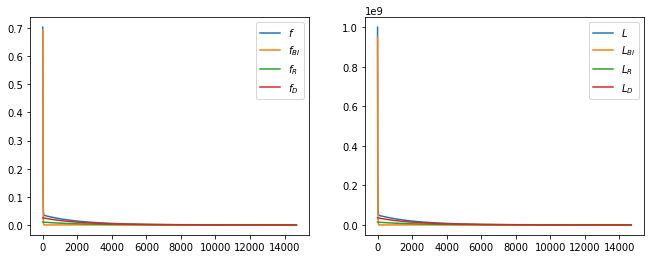

In [15]:
t_plot = np.where(f_a[0]==0)[0][0]
make_plots(f_a, L_a, t_plot)

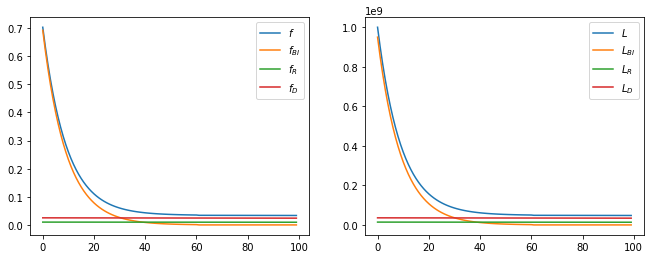

In [16]:
make_plots(f_a, L_a, 100)

In [17]:
print_stats(f_a, L_a, _t_max=200)

Total recovery after 14684 days.
Damage / Reconstruction recovery after ~40.23 years
Business Interruption recovery after 61 days


Initial reconstruction share factor alpha is 0.01.
Total loss is USD 115.13bn.
Of this loss, 7.99% is due to BI, 26.26% due to R, 65.75% due to D


Total loss until day 200 is USD 18.76bn.
Of this loss, 49.02% is due to BI, 14.49% due to R, 36.49% due to D


### Parameter Set 2 - Variation of alpha
- $D_0 = \text{\$} 30.233$bn
- $t_{r,BI} = 60$
- $f_{r_BI} = 0.001$
- $\alpha = 0.05$
- $f_{r, R} = 0.001$

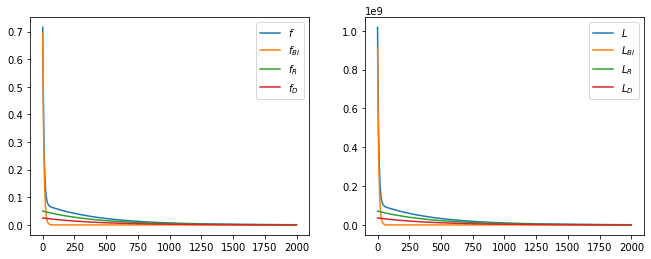

In [18]:
make_plots(*get_total_forcing('a', _t_max=30000, _alpha=0.05), 2000)

In [19]:
print_stats(*get_total_forcing('a', _t_max=30000, _alpha=0.05), _t_max=200)

Total recovery after 2935 days.
Damage / Reconstruction recovery after ~8.04 years
Business Interruption recovery after 61 days


Initial reconstruction share factor alpha is 0.05.
Total loss is USD 54.20bn.
Of this loss, 16.29% is due to BI, 55.78% due to R, 27.93% due to D


Total loss until day 200 is USD 25.92bn.
Of this loss, 34.06% is due to BI, 43.85% due to R, 22.09% due to D


### Parameter Set 3 - Variation of $f_{r, BI}$ and $f_{r, R}$
- $D_0 = \text{\$} 30.233$bn
- $t_{r,BI} = 60$
- $f_{r_BI} = 0.01$
- $\alpha = 0.05$
- $f_{r, R} = 0.01$

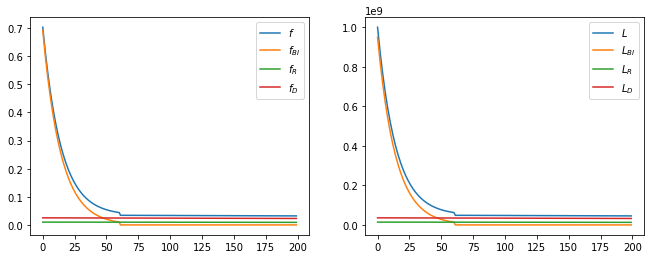

In [20]:
make_plots(*get_total_forcing('a', _t_max=30000, _f_r_bi=0.01, _f_r_R=0.01), 200)

In [21]:
print_stats(*get_total_forcing('a', _t_max=30000, _f_r_bi=0.01, _f_r_R=0.01), _t_max=200)

Total recovery after 14684 days.
Damage / Reconstruction recovery after ~40.23 years
Business Interruption recovery after 61 days


Initial reconstruction share factor alpha is 0.01.
Total loss is USD 119.69bn.
Of this loss, 11.50% is due to BI, 25.26% due to R, 63.25% due to D


Total loss until day 200 is USD 23.32bn.
Of this loss, 59.00% is due to BI, 11.65% due to R, 29.35% due to D


## 2.2 Recovery Variant b ($t_{r,R}$ set)

### Parameter Set 1
- $D_0 = \text{\$} 30.233$bn
- $t_{r,BI} = 60$
- $f_{r_BI} = 0.001$
- $t_{r,R} = 4*365$
- $f_{r, R} = 0.001$

In [22]:
f_b, L_b = get_total_forcing('b', _t_max=30000)

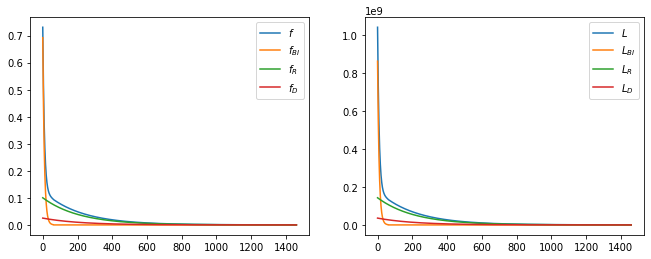

In [23]:
t_plot = np.where(f_b[0]==0)[0][0]
make_plots(f_b, L_b, t_plot)

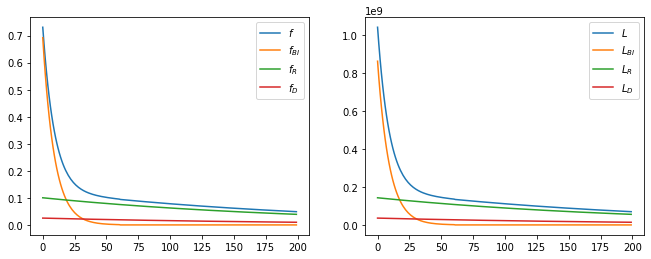

In [24]:
make_plots(f_b, L_b, 200)

In [25]:
print_stats(f_b, L_b, _t_max=200)

Total recovery after 1461 days.
Damage / Reconstruction recovery after ~4.00 years
Business Interruption recovery after 61 days


Initial reconstruction share factor alpha is 0.10.
Total loss is USD 46.16bn.
Of this loss, 18.16% is due to BI, 65.50% due to R, 16.34% due to D


Total loss until day 200 is USD 31.54bn.
Of this loss, 26.57% is due to BI, 58.70% due to R, 14.73% due to D


### Parameter Set 2 - Variation of $t_{r,R}$
- $D_0 = \text{\$} 30.233$bn
- $t_{r,BI} = 60$
- $f_{r_BI} = 0.001$
- $t_{r,R} = 6*365$
- $f_{r, R} = 0.001$

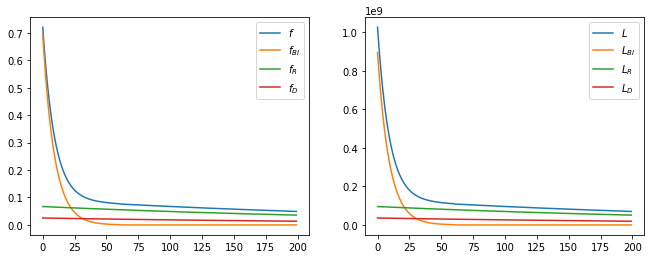

In [26]:
make_plots(*get_total_forcing('b', _t_max=30000, _t_r_R=6*365), 200)

In [27]:
print_stats(*get_total_forcing('b', _t_max=30000, _t_r_R=6*365), _t_max=200)

Total recovery after 2191 days.
Damage / Reconstruction recovery after ~6.00 years
Business Interruption recovery after 61 days


Initial reconstruction share factor alpha is 0.07.
Total loss is USD 50.22bn.
Of this loss, 17.28% is due to BI, 60.21% due to R, 22.52% due to D


Total loss until day 200 is USD 28.16bn.
Of this loss, 30.81% is due to BI, 50.28% due to R, 18.91% due to D


## Comparison with old Forcing

The old forcing was generated similarly to the function *get_recovery_curve_a* in this script, setting the initial reconstruction effort to the value that corresponds to the initial business interruption in this setup. 

The area under the forcing curve was then set to match the total disaster loss, however as baseline production the baseline values from the EORA network were used instead of the BEA GDP values like in this setup.

The total disaster loss was calculated as $L = r D_0$ 

Note that also the asset-to-gdp value previously had a calculation error and is now smaller (before ~3, now ~2.3).

In [28]:
def get_forcing_old(_state='NJ', _D_0=30.233e9, _f_r_R_old=0.001, _t_max=1000):
    r = pd.read_csv('/home/robin/repos/hurricanes_hindcasting_remake/forcing_gen/data/Asset-GDP-ratio_by_major_sector_10y_mean_1960-2012.csv')
    r = r.set_index('Sector').loc['TOT', str(year)]

    L_tot_old = r * _D_0

    f_0_old = get_bi_curve(_state=_state)[0]
  
    baseline_old = Dataset('/home/robin/repos/hurricanes_hindcasting_remake/forcing_gen/data/baseline/EORA_{}/output.nc'.format(year))
    region_index = np.where(baseline_old['/region'][:] == 'US.'+_state)[0][0]
    X_star_old = baseline_old['agents/production'][0, :, region_index].sum() * 1e3
    
    L_R_0_old = f_0_old * X_star_old
    tau_R_old = -1 / np.log((L_tot_old / L_R_0_old - 1) / (L_tot_old / L_R_0_old - _f_r_R_old))
    t_r_old = int(np.ceil(-np.log(_f_r_R_old) * tau_R_old))
    L_old = L_R_0_old * np.exp(-np.arange(_t_max) / tau_R_old)
    if t_r_old <= _t_max:
        L_old[t_r_old] = L_tot_old - L_old[:t_r_old].sum()
    if _t_max > t_r_old:
        L_old[t_r_old+1:] = 0

    f_old = L_old / X_star_old

    X_star_new = get_baseline_production(_state)
    L_old_adjusted = f_old * X_star_new
    return f_old, L_old, L_old_adjusted

**New York**

In [29]:
f_old_NY, _, L_old_NY = get_forcing_old('NY')
f_old_NY, L_old_NY = tuple([f_old_NY] + [np.zeros(len(f_old_NY))] * 3), tuple([L_old_NY] + [np.zeros(len(L_old_NY))] * 3)
print_stats(f_old_NY, L_old_NY, _t_max=200)

Total recovery after 109 days.
Damage / Reconstruction recovery after ~0.00 years
Business Interruption recovery after 0 days


Initial reconstruction share factor alpha is 0.00.
Total loss is USD 46.58bn.
Of this loss, 0.00% is due to BI, 0.00% due to R, 0.00% due to D


Total loss until day 200 is USD 46.58bn.
Of this loss, 0.00% is due to BI, 0.00% due to R, 0.00% due to D


**New Jersey**

In [30]:
f_old_NJ, _, L_old_NJ = get_forcing_old('NJ')
f_old_NJ, L_old_NJ = tuple([f_old_NJ] + [np.zeros(len(f_old_NJ))] * 3), tuple([L_old_NJ] + [np.zeros(len(L_old_NJ))] * 3)
print_stats(f_old_NJ, L_old_NJ, _t_max=200)

Total recovery after 322 days.
Damage / Reconstruction recovery after ~0.00 years
Business Interruption recovery after 0 days


Initial reconstruction share factor alpha is 0.00.
Total loss is USD 46.13bn.
Of this loss, 0.00% is due to BI, 0.00% due to R, 0.00% due to D


Total loss until day 200 is USD 45.56bn.
Of this loss, 0.00% is due to BI, 0.00% due to R, 0.00% due to D


### Comparison Setup a
a1:
- Variant a
- $D_0 = \text{\$} 30.233$bn
- $t_{r,BI} = 60$
- $f_{r_BI} = 0.001$
- $\alpha = 0.01$
- $f_{r, R} = 0.001$

a2:
- Variation to $\alpha = 0.05$

### Comparison Setup b
b1: 
- Variant b
- $D_0 = \text{\$} 30.233$bn
- $t_{r,BI} = 60$
- $f_{r_BI} = 0.001$
- $f_{r, R} = 0.001$
- $t_{r,R} = 4*365$ 

b2:
- Variation to $t_{r,R} = 6*365$


In [31]:
setups = {
    'new_a_1': {'recovery_variant': 'a', '_t_max': 30000},
    'new_a_2': {'recovery_variant': 'a', '_t_max': 30000, '_alpha': 0.05},
    'new_b_1': {'recovery_variant': 'b', '_t_max': 30000},
    'new_b_2': {'recovery_variant': 'b', '_t_max': 30000, '_t_r_R': 6*365},
}
setup_params = {}
for setup, setup_param in setups.items():
    setup_params[setup] = {}
    for _state in ['NJ', 'NY']:
        setup_params[setup][_state] = {**setup_param, **{'_state': _state}}

f = {
    'old': {
        'NJ': f_old_NJ,
        'NY': f_old_NY,
    },
}

L = {
    'old': {
        'NJ': L_old_NJ,
        'NY': L_old_NY,
    },
} 

for setup_key in setup_params.keys():
    f[setup_key] = {}
    L[setup_key] = {}
    for state, params in setup_params[setup_key].items():
        f_, L_ = get_total_forcing(**params)
        f[setup_key][state] = f_
        L[setup_key][state] = L_

In [32]:
for setup_key in f.keys():
    for state in ['NY', 'NJ']:
        print("\033[1m" + state + ": " + setup_key + "\033[0m")
        print_stats(f[setup_key][state], L[setup_key][state], _t_max=200)
        print("\n\n")

NY: old
Total recovery after 109 days.
Damage / Reconstruction recovery after ~0.00 years
Business Interruption recovery after 0 days


Initial reconstruction share factor alpha is 0.00.
Total loss is USD 46.58bn.
Of this loss, 0.00% is due to BI, 0.00% due to R, 0.00% due to D


Total loss until day 200 is USD 46.58bn.
Of this loss, 0.00% is due to BI, 0.00% due to R, 0.00% due to D



NJ: old
Total recovery after 322 days.
Damage / Reconstruction recovery after ~0.00 years
Business Interruption recovery after 0 days


Initial reconstruction share factor alpha is 0.00.
Total loss is USD 46.13bn.
Of this loss, 0.00% is due to BI, 0.00% due to R, 0.00% due to D


Total loss until day 200 is USD 45.56bn.
Of this loss, 0.00% is due to BI, 0.00% due to R, 0.00% due to D



NY: new_a_1
Total recovery after 5764 days.
Damage / Reconstruction recovery after ~15.79 years
Business Interruption recovery after 61 days


Initial reconstruction share factor alpha is 0.01.
Total loss is USD 86.96bn.

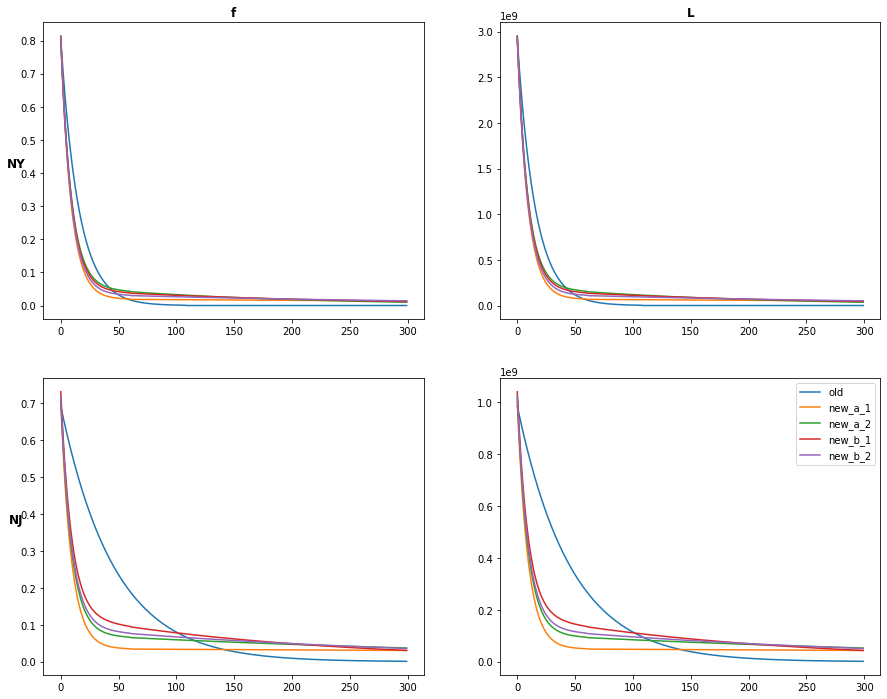

In [33]:
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
for setup_key in f.keys():
    for row, state in enumerate(['NY', 'NJ']):
        clip = 300# if state == 'NJ' else 150
        axs[row, 0].plot(f[setup_key][state][0][:clip])
        axs[row, 1].plot(L[setup_key][state][0][:clip], label=setup_key)
axs[0, 0].set_title('f',rotation=0, fontsize=12, fontweight='bold')
axs[0, 1].set_title('L',rotation=0, fontsize=12, fontweight='bold')
axs[0, 0].set_ylabel('NY',rotation=0, fontsize=12, fontweight='bold')
axs[1, 0].set_ylabel('NJ',rotation=0, fontsize=12, fontweight='bold')
axs[1, 1].legend()

# 3 Forcing Output

Write generated forcing curves to a netcdf-File for Acclimate, using some parameter selection

In [34]:
parameter_selection = 'new_b_1'
forcing_duration = 4*365

In [35]:
all_sectors = ['FCON', 'AGRI', 'FISH', 'MINQ', 'FOOD', 'TEXL', 'WOOD', 'OILC', 'METL', 'MACH', 'TREQ', 'MANU', 'RECY', 'ELWA', 'CONS', 'REPA', 'WHOT', 'RETT', 'GAST', 'TRAN', 'COMM', 'FINC', 'ADMI', 'EDHE', 'HOUS', 'OTHE', 'REXI']

In [36]:
def write_ncdf_output(_forcing_curves, _sector_list, _out_dir, _out_name):
    max_len = max([len(curve) for curve in _forcing_curves.values()])
    with Dataset(path.join(_out_dir, _out_name + '.nc'), 'w') as outfile:
        timedim = outfile.createDimension("time")
        timevar = outfile.createVariable("time", "f", "time")
        timevar[:] = np.arange(0, max_len)
        timevar.units = "days since 2009-01-01"
        timevar.calendar = "standard"

        regions = list(_forcing_curves.keys())
        regiondim = outfile.createDimension("region", len(regions))
        regionvar = outfile.createVariable("region", str, "region")
        for i, r in enumerate(regions):
            regionvar[i] = r

        sectors = _sector_list
        sectordim = outfile.createDimension("sector", len(sectors))
        sectorvar = outfile.createVariable("sector", str, "sector")
        for i, s in enumerate(sectors):
            sectorvar[i] = s

        forcing = outfile.createVariable("forcing", "f", ("time", "sector", "region"), zlib=True, complevel=7,
                                         fill_value=1.0)
        for reg, forcing_ts in _forcing_curves.items():
            for sec in sectors:
                forcing[:, sectors.index(sec), regions.index(reg)] = forcing_ts

In [40]:
forcing_curves_bi = {}
forcing_curves_bi_d = {}
forcing_curves_bi_d_r = {}
for region, (_f, _f_bi, _f_R, _f_D) in f[parameter_selection].items():
    forcing_curves_bi['US.' + region] = - _f_bi[:forcing_duration] + 1
    forcing_curves_bi_d['US.' + region] = -(_f_D + _f_bi * (1 - _f_D))[:forcing_duration] + 1
    forcing_curves_bi_d_r['US.' + region] = - _f[:forcing_duration] + 1

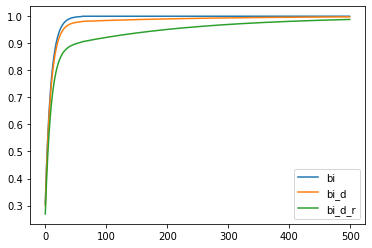

In [44]:
plt.plot(forcing_curves_bi['US.NJ'][:500], label='bi')
plt.plot(forcing_curves_bi_d['US.NJ'][:500], label='bi_d')
plt.plot(forcing_curves_bi_d_r['US.NJ'][:500], label='bi_d_r')
plt.legend()

In [46]:
write_ncdf_output(forcing_curves_bi, all_sectors, "../data/forcing/", "sandy_forcing_bi")
write_ncdf_output(forcing_curves_bi_d, all_sectors, "../data/forcing/", "sandy_forcing_bi_d")
write_ncdf_output(forcing_curves_bi_d_r, all_sectors, "../data/forcing/", "sandy_forcing_bi_d_r")